
This workshop provided an introduction to using NLP techniques to analyze tweets related to the 2024 US election. Critically, the workshop demonstrated how NLP can be used to automatically quantify the meaning of narratives, providing a powerful tool for psychological research.

**Key Topics Covered (see [this paper](https://www.cell.com/trends/cognitive-sciences/abstract/S1364-6613(25)00054-3) by myself and colleagues) for detail: ***

* Data Preprocessing: Cleaning and preparing tweet data for analysis.
* Linguistic Feature Analysis: Using lexicons and sentiment analysis tools like Empath and VADER to quantify the emotional tone and valence of tweets.
* Text Vectorization and Embedding: Applying Universal Sentence Encoder (USE) to represent tweets as numerical vectors and calculate semantic similarity between them. This was used to investigate which party was viewed with more varied opinions.
* Topic Modeling (if there's time): Using Structural Topic Modeling (STM) to identify hidden themes and topics within the collection of tweets and exploring their association with different political parties.

**Workshop Highlights:**

* Hands-on experience with popular NLP tools and techniques in Python and R.
* Practical examples of applying NLP to real-world data, specifically tweets related to the 2024 US election.
* Discussion of the limitations of NLP models and how to mitigate them.
* Guidance on interpreting and visualizing the results of NLP analysis.

**Overall Learning Outcomes:**

By the end of the workshop, participants gained a foundational understanding of NLP concepts and techniques, as well as the ability to apply them to analyze text data for extracting meaningful insights. The goal is to demystify NLP to psychologists, and to show that it doesn't take a computer science degree to utilize NLP in their daily research.

*Disclaimer: The tweets used in this analysis are for illustrative purposes only and do not reflect the personal opinions or beliefs of the author. They are sourced from publicly available data and are used to demonstrate the capabilities of NLP tools.*

# Preparation

In [1]:
# upload data.xlsx to the notebook
from google.colab import files #upload files to google colab
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [2]:
import pandas as pd #for dataframe management
import numpy as np #complex math
import re #replacing text
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting

In [3]:
data = pd.read_excel('data.xlsx')

# Data Preprocessing
An essential initial step in Natural Language Processing (NLP) is data cleaning, particularly when dealing with online text like tweets, online surveys, or other participant-generated content. This process ensures your data is accurate, consistent, and ready for analysis, ultimately leading to more reliable insights.

In this document, some data cleaning is already completed before python using excel. This includes selecting only English tweets, only tweets with more than 20 likes, and replacing recoding errors (e.g., showing â€™ for ')

The preprocessing steps here are very basic and for illustrative purposes. Depending on your dataset, NLP methods, and question, additional cleaning may involve stop word removal, stemming, tokenization, spell checking, punctuation removal etc. For instance, LIWC requires the most amount of cleaning, and text embedding requires the least amount.

In [4]:
# additional cleaning in python
def clean_election(text):

    new_text = re.sub(r'<...>',' ', text)  # remove html tags <...>
    new_text = re.sub(r'http\S+', ' ', new_text) # removed all URLs
    new_text = re.sub(r'[^\x00-\x7F]+', ' ', new_text) # remove non-english characters

    # you may decide to remove additional texts depending on the question.
    # For example, usernames can be quite useful in determining who the tweets are
    # about, so I kept them here. But you can remove them if this info is not
    # necessary.

    new_text = new_text.lower() # convert all characters to lowercase.

    new_text = new_text.replace("\n",' ') # remove b'
    new_text = new_text.replace('\\n',' ') # remove \\n

    return new_text

In [5]:
len(data)

2999

In [6]:
data.head()

,text,date
0,BREAKING: Florida Governor Ron DeSantis is sen...,2024-11-26
1,@NormOrnstein Norman Jay Ornstein â€œ playing ...,2024-11-26
2,General Flynn was so well respected by Preside...,2024-11-26
3,( @realDonaldTrump - Truth Social Post )\n( Do...,2024-11-26
4,"Walmart rolls back diversity, equity, and incl...",2024-11-26


In [7]:
data = data.dropna() #drop empty rows
data['text'] = data['text'].apply(clean_election)

In [8]:
# separate the data into those about republicans and those about democrats
# and only pick tweets referring to only one of them
data['republican'] = data['text'].str.contains('trump|republican|republicans', case=False).astype(int)
data['democrat'] = data['text'].str.contains('harris|biden|democrat|democrats', case=False).astype(int)
data = data[data['republican'] != data['democrat']].reset_index(drop=True)

In [9]:
data.head()

,text,date,republican,democrat
0,general flynn was so well respected by preside...,2024-11-26,1,0
1,( @realdonaldtrump - truth social post ) ( don...,2024-11-26,1,0
2,rumor ripple ceo brad garlinghouse might be...,2024-11-26,1,0
3,@realalexjones @genflynn the military needs to...,2024-11-26,0,1
4,"in a huge legal victory for donald trump, a us...",2024-11-26,1,0


# Linguistic Feature Analysis
One of the earliest forms of NLP involved extracting linguistic features from text or speech to
understand the cognitive processes underlying narrations. A popular lexicon-based method for text analysis is linguistic inquiry and word count (LIWC). LIWC uses over 100 predefined lexicons to score a given document in terms of its usage of basic parts of speech (e.g., pronouns, nouns, verbs) or how it refers to more abstract psychological features (e.g., social referents, emotion, past/future focused), providing a useful approach to identify characteristics of language use between scenarios and across groups. LIWC is not free to use, so here we will use a free alternative, Empath. Note that Empath is not a great option for reasons below. For actual research purposes, LIWC is still much more recommended. We will also introduce a similar package focused on valence, VADER.

In [11]:
# !pip install empath vaderSentiment

In [12]:
from empath import Empath #Empath package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER package

In [13]:
def sentiment_empath(text):
  lexicon = Empath()
  result = lexicon.analyze(text, categories=["positive_emotion","negative_emotion"], normalize=True) #linguistic feature analysis
  positive = result["positive_emotion"]
  negative = result["negative_emotion"]
  return positive, negative

In [14]:
df = data.copy()

In [15]:
# count the percentage of positive and negative emotion words in all tweets
df['positive_empath'], df['negative_empath'] = zip(*df['text'].apply(sentiment_empath))

In [16]:
# tweets with the most positive words
df = df.sort_values(by=['positive_empath'], ascending=False).reset_index(drop=True)
df.head()

,text,date,republican,democrat,positive_empath,negative_empath
0,biden is so happy,2024-11-26,0,1,0.250000,0.0
1,@chrisdjackson @flotus @drbiden love her #maga...,2024-11-26,0,1,0.142857,0.0
2,"donald trump ripples happy ripples, happy ...",2024-11-18,1,0,0.133333,0.0
3,@thejackhopkins i just hope biden is not too p...,2024-11-26,0,1,0.133333,0.0
4,@bronzeaya i wish biden was 10 years younger.,2024-11-18,0,1,0.125000,0.0


In [17]:
# tweets with the most negative words
df = df.sort_values(by=['negative_empath'], ascending=False).reset_index(drop=True)
df.head()

,text,date,republican,democrat,positive_empath,negative_empath
0,@popcrave republicans are fucking evil,2024-11-26,1,0,0.0,0.200000
1,@ivankanews_ nato and joe fucking biden,2024-11-26,0,1,0.0,0.166667
2,biden harris didn't slaughter anyone hamas s...,2024-11-26,0,1,0.0,0.157895
3,democrats want this or they just don't care. ...,2024-11-18,0,1,0.0,0.142857
4,@bennyjohnson what isn't wrong with hunter biden?,2024-11-18,0,1,0.0,0.142857


Empath can tell apart positive tweets (e.g., Biden is so happy) from negative tweets (e.g., republicans are f-ing evil). However, a big drawback is that is cannot consider the relationships between words. For instance, "I am not happy" is rated as more positive than negative.

In [18]:
lexicon = Empath()
lexicon.analyze('I am not happy', categories=["positive_emotion","negative_emotion"], normalize=True)

{'positive_emotion': 0.25, 'negative_emotion': 0.0}

LIWC (although with much better validated dictionaries) suffers from the same issue of word relationships. More recent models, like VADER, tracks word order-sensitive relationships between terms to compute the emotional tone of a text (i.e., positive to negative valence). Instead of relying exclusively on a lexicon with a fixed mapping between a word and valence, VADER also tracks punctuation (e.g., !) and intensifiers (e.g., extremely, some-what, kind of), affording it additional sensitivity to the degree of the sentiment being expressed.

The positive, neutral, and negative scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). The compound score (which is calculated below) is computed by summing the valence scores and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In [19]:
analyzer = SentimentIntensityAnalyzer()
result = analyzer.polarity_scores('I am not happy')
result['compound'] # 1 is positive, -1 is negative

-0.4585

In [20]:
result = analyzer.polarity_scores('I am not happy!')
result['compound']

-0.509

In [21]:
def sentiment_vader(text):
  result = analyzer.polarity_scores(text) #linguistic feature analysis
  return result['compound']

In [22]:
df['valence_vader'] = df['text'].apply(sentiment_vader)

In [23]:
df = df.sort_values(by=['valence_vader'], ascending=True).reset_index(drop=True)
df.head()

,text,date,republican,democrat,positive_empath,negative_empath,valence_vader
0,just a daily reminder that donald trump is a ...,2024-11-18,1,0,0.0,0.020408,-0.9890
1,hey how's that wall that trump repeatedly sa...,2024-11-26,1,0,0.0,0.020408,-0.9721
2,donald trump's decision to place the same 25% ...,2024-11-26,1,0,0.0,0.000000,-0.9646
3,"listen to this, every second of it, and never ...",2024-11-18,0,1,0.0,0.000000,-0.9580
4,"@derrickevans4wv quite a few: nancy ""insider t...",2024-11-26,0,1,0.0,0.000000,-0.9578


In [24]:
# the most negative tweet
df.at[0, 'text']

'just  a daily reminder that donald trump is a convicted sex offender, liar,  felon, and financial fraudster and is a racist, sexist, hateful, fear  mongering, evil fascist and is the worst president in the history of the  u.s. and deserves to spend the rest of his life in prison,  '

In [25]:
df = df.sort_values(by=['valence_vader'], ascending=False).reset_index(drop=True)
df.head()

,text,date,republican,democrat,positive_empath,negative_empath,valence_vader
0,@harryjoebanks34 yeah... joe biden trying to s...,2024-11-18,0,1,0.064516,0.0,0.9724
1,@inga_c8 wasn't ronald reagan just the best?? ...,2024-11-26,1,0,0.068966,0.0,0.9639
2,"it's good to be a rich, white criminal in amer...",2024-11-26,1,0,0.000000,0.0,0.9509
3,"under president donald trump, the united state...",2024-11-26,1,0,0.000000,0.0,0.9483
4,"just listening to a speech by the maga token ""...",2024-11-26,1,0,0.000000,0.0,0.9447


In [26]:
# the most positive tweet
df.at[0, 'text']

"@harryjoebanks34 yeah... joe biden trying to start wwiii.  fck off indeed. so glad it's maga time! world peace, booming economy, annnnd! justice!  wooooooooooooooooooooooooooooo!!!!  real joy! feel it! love it! live it!  "

But also consider this example, particularly the phrase 'best destructionist: Gavin Newsom.' While the user's intent is clearly sarcastic and critical of Newsom, VADER and many other NLP tools struggle to detect such nuanced sentiment to a degree.

In [27]:
result = analyzer.polarity_scores('best destructionist: Gavin Newsom')
result['compound'] # 1 is positive, -1 is negative

0.1531

In [28]:
# they struggle but only to a degree: despite the comment above being scored as
# positive, it is still much lower than a truly positive comment like this
result = analyzer.polarity_scores('best governor: Gavin Newsom')
result['compound'] # 1 is positive, -1 is negative

0.6369

While NLP models like VADER can struggle with nuances like sarcasm, we often rely on the abundance of data to mitigate these imperfections and reveal broader trends. Let's now shift our focus to analyze which political party is generally perceived more positively within our dataset.

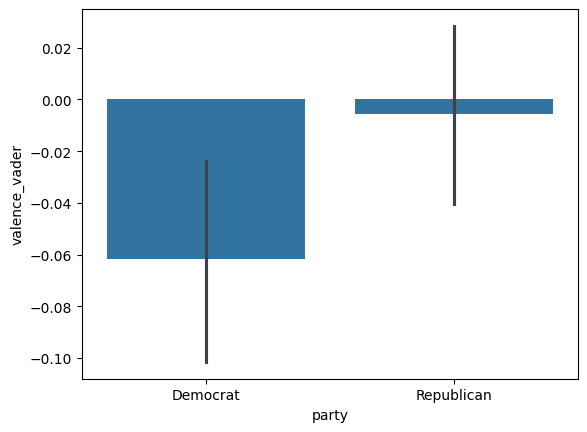

In [29]:
sns.barplot(data=df, x='republican', y='valence_vader')
plt.xticks([0, 1], ['Democrat', 'Republican'])
plt.xlabel('party')
plt.show()

Our analysis shows that Democrats received a lower average sentiment score compared to Republicans. This observation aligns with the outcome of the election. In conclusion, Linguistic Feature Analysis offers a straightforward and accessible method for automatically analyzing text data. Often achievable with minimal code, it can reveal valuable insights into the overall sentiment, prevalent topics, and word usage patterns within a text. However, it's crucial to acknowledge its limitations in discerning complex relationships between words, and its susceptibility to misinterpreting irony and sarcasm.

# Text Vectorization and Embedding
In brief, embedding models convert a given text (e.g., word, sentence, or document) into numerical vectors, thus ‘embedding’ the text vectors in a high-dimensional semantic space. These ‘spaces’ are derived from large corpora of natural text (e.g., entirety of Wikipedia) and represent semantics by inferring what a word means based on how it was used in the training corpus. The specific ways in which embeddings are computed vary considerably, from directly modeling word occurrence statistics (e.g., Global Vectors for Word Representation (GLoVe)) to training neural networks to complete a specific task, like predicting the text that is likely to appear before or after a specific target [e.g., word2vec and Universal Sentence En-coder (USE)]. Yet, contemporary embedding models leverage the powerful transformer architecture (e.g., Bidirectional Encoder Representations from Transformers (BERT)), which has given rise to the proliferation of LLMs that we see today [e.g., Generative Pretrained Transformer (GPT)].

The purpose of this workshop is not about how USE is computed, but rather how to use the resulting vector. Here, I will demonstrate a simple use of text embedding: similarity in meaning, often used to quantify narrative memory accuracy and consistency.

You can also different analyses on the resulting vector. For instance, you can use the vector as the input to train a classifier of words (e.g., positive vs negative; internal vs external), or represent your dataset into a 2D space where texts closer in meaning are closer in distance.

In [30]:
import tensorflow_hub as hub
USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [31]:
def USE_similarity(USE, sentence1, sentence2):
  #convert sentence1 and sentence2 into 512-dimensional vectors
  USE_output = np.array(USE([sentence1, sentence2]))
  # calculate cosine distance between them to quantify similarity
  similarity = np.inner(USE_output[0], USE_output[1])
  return similarity

# Note: For those interested in the math, the function np.inner actually
# calculates the inner product between inputs. Cosine similarity is the inner
# product, normalized by the magnitudes of the vectors. Since the magnitudes of
# USE vectors are always 1, in this case, cosine similarity and the inner
# product are equivalent. Consequently, using the inner product directly
# provides a measure of semantic similarity between the input sentences.

In [32]:
sentence1 = 'I like apple'
sentence2 = 'I like apple pie'
USE_similarity(USE, sentence1, sentence2)

np.float32(0.7040262)

In [33]:
sentence1 = 'I like apple'
sentence2 = 'Gravity pulls objects downward'
USE_similarity(USE, sentence1, sentence2)

np.float32(0.074745)

In [41]:
# USE can also deal with typos to a degree
sentence1 = 'I like apple'
sentence2 = 'I like aple'
USE_similarity(USE, sentence1, sentence2)

np.float32(0.6081179)

In [34]:
# note: USE focuses on semantic similarity, not the direction of the sentiment
# so two opposite opinions on the same topic get scored as highly similar
sentence1 = 'I like apple'
sentence2 = 'I do not like apple'
USE_similarity(USE, sentence1, sentence2)

np.float32(0.77399945)

One way to leverage text similarity is to identify which political party is viewed more diversely. By tagging tweets based on party affiliation and calculating the pairwise similarity between tweets within each party, we can compare the average similarity scores. A lower average similarity suggests greater diversity of opinions.

In [42]:
df['democrat'].value_counts()

,count
democrat,
0,841
1,668


In [43]:
# To ensure a balanced comparison and reduce computation time for this demonstration,
# we'll randomly sample 100 tweets for each political party. This addresses
# potential bias due to varying numbers of tweets per party.

republican_sample = df[df['republican'] == 1].sample(n=100, random_state=42)
democrat_sample = df[df['democrat'] == 1].sample(n=100, random_state=42)
df = pd.concat([republican_sample, democrat_sample]).reset_index(drop=True)

In [44]:
df['democrat'].value_counts()

,count
democrat,
0,100
1,100


In [45]:
# create a new dataframe to compute pairwise similarities between any two tweets
# referring to the same party
parties,text1s,text2s = [],[],[]
for party in ['democrat','republican']:
    df_sub = df[df[party] == 1].reset_index(drop=True)
    for i in range(len(df_sub)):
        for j in range(i):
            parties.append(party)
            text1s.append(df_sub.at[j,'text'])
            text2s.append(df_sub.at[i,'text'])

df_pair = pd.DataFrame({'party':parties, 'text1':text1s, 'text2':text2s})

In [46]:
# here, I used the same USE_similarity function to keep it simple
# for faster computation speed, convert all tweets to vectors and then carry
# out matrix computation
df_pair['similarity'] = df_pair.apply(
    lambda x: USE_similarity(USE, x['text1'], x['text2']), axis=1)

In [47]:
df_pair.head()

,party,text1,text2,similarity
0,democrat,is the biden regime trying to start wwiii?,@bennyjohnson what is not wrong with hunter bi...,0.472642
1,democrat,is the biden regime trying to start wwiii?,if biden or any democrat tried to fire workers...,0.393672
2,democrat,@bennyjohnson what is not wrong with hunter bi...,if biden or any democrat tried to fire workers...,0.364495
3,democrat,is the biden regime trying to start wwiii?,@0liviajulianna joe biden already has tariffs....,0.541393
4,democrat,@bennyjohnson what is not wrong with hunter bi...,@0liviajulianna joe biden already has tariffs....,0.539890


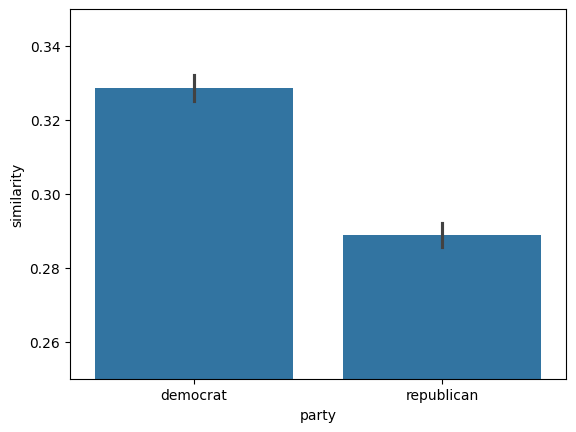

In [48]:
sns.barplot(data=df_pair, x='party', y='similarity')
plt.ylim(0.25, 0.35)
plt.show()

Our analysis using text embedding suggests that public opinion towards the Republican party was more diverse compared to the Democratic party. It's important to note that a more rigorous statistical analysis, such as hierarchical modeling or bootstrapping, would be necessary to account for the interdependence of pairwise similarity scores. However, such analysis is beyond the scope of this workshop and thus is not performed

# Topic Modeling
Topic modeling aims to uncover hidden themes within a collection of texts by identifying groups of words that frequently appear together. A popular method is Latent Dirichlet Allocation (LDA), which uses machine learning to discover these themes and assign words to them with varying probabilities (topic weights). This approach allows for analyzing the distribution of multiple topics within a single text, which can then be compared across situations.  While embedding approaches are useful for comparing narratives, topic modeling is particularly valuable for exploring the content of individual narratives, a key interest for memory scientists. Here, we use an implementation of LDA: structural topic model (STM)



In [49]:
df = data.copy()
df['party'] = df['republican'].apply(lambda x: 'republican' if x == 1 else 'democrat')

In [50]:
# import rpy2 to use R in jupyter notebook
import rpy2
import rpy2.robjects.packages as rpackages

In [51]:
%load_ext rpy2.ipython

In [53]:
# install stm package
# utils = rpackages.importr('utils')
# utils.install_packages('stm')
# utils.install_packages('tm')

Here, we will use structural topic model (STM), an implementation of LDA optimized for comparison across situations (i.e., metadata). STM has additional preprocessing steps like stop word removal built in. It also requires a predefined number of topics (K). Typically, you should determine K in a data driven way, such as by balancing similarity within a topic and dissimilarity across different topics. Here, we will use K = 10 for simplicity's sake. It is also recommended to use texts longer than a tweet with STM.

In [54]:
df

,text,date,republican,democrat,party
0,general flynn was so well respected by preside...,2024-11-26,1,0,republican
1,( @realdonaldtrump - truth social post ) ( don...,2024-11-26,1,0,republican
2,rumor ripple ceo brad garlinghouse might be...,2024-11-26,1,0,republican
3,@realalexjones @genflynn the military needs to...,2024-11-26,0,1,democrat
4,"in a huge legal victory for donald trump, a us...",2024-11-26,1,0,republican
...,...,...,...,...,...
1504,what is in hunter biden's laptop? more... z...,2024-11-18,0,1,democrat
1505,there is a pop culture shift happening in amer...,2024-11-18,1,0,republican
1506,"not to rush things, but biden now has 63 days ...",2024-11-18,0,1,democrat
1507,"@zigmanfreud 'multiple flip flops on trump, ve...",2024-11-18,1,0,republican


In [55]:
%%R -i df
library(stm)
processed <- textProcessor(documents = df$text, metadata = df, verbose=TRUE)
out <- prepDocuments(documents = processed$documents,
                          vocab = processed$vocab, meta = processed$meta,
                          lower.thresh = 5)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 4168 of 4987 terms (7153 of 23766 tokens) due to frequency 
Your corpus now has 1509 documents, 819 terms and 16613 tokens.

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


In [56]:
%%R
fit <- stm(documents = out$documents, vocab = out$vocab, K = 10,
           prevalence =~ party,
           data = out$meta, init.type = "Spectral", verbose=FALSE)
prep <- estimateEffect(1:10 ~ party, fit,
                       meta = out$meta, uncertainty = "Global")

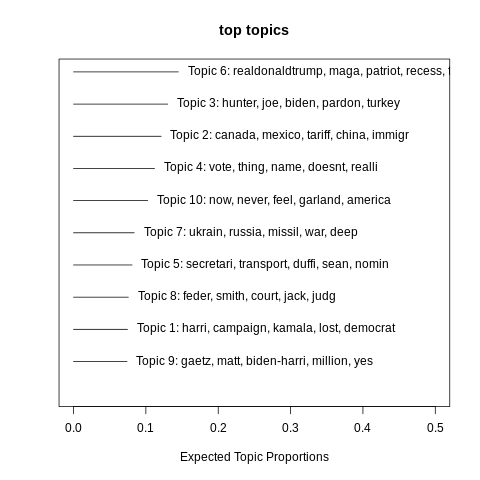

In [57]:
%%R
plot(fit, type = "summary", labeltype='frex', xlim = c(0, 0.5), n=5,
     main='top topics')

STM is based on word probabilities and, unlike text embedding, is agnostic to the semantic meaning of words. Despite this, we observe that topics related to prominent events, such as Donald Trump's election victory, discussions of a potential pardon for Hunter Biden, tariffs imposed on Canada and Mexico, and the war in Ukraine, emerged as distinct themes. We can now assess which topics are most strongly associated with each party based on the tweets that mention them, and analyze how different parties are discussed within the same topic.

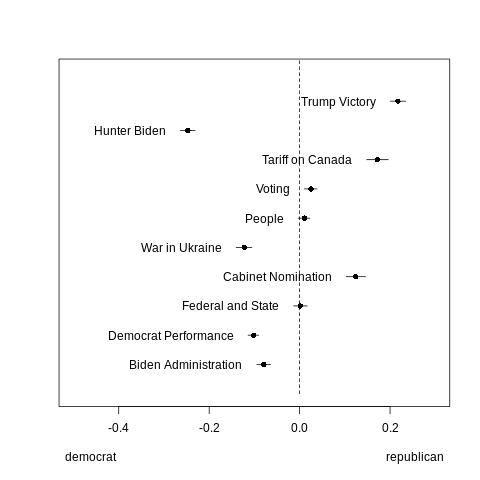

In [58]:
%%R
type_diff <- plot(prep, covariate = "party", method = "difference", model = fit,
     cov.value1 = "republican", cov.value2 = "democrat",
     labeltype = "custom", verbose.labels = TRUE, n = 3,
     xlab = "democrat                                                                                          republican",
     topics=c(6,3,2,4,10,7,5,8,1,9),
     custom.labels=c('Trump Victory','Hunter Biden',
                     'Tariff on Canada','Voting',
                     'People','War in Ukraine',
                     'Cabinet Nomination','Federal and State',
                     'Democrat Performance','Biden Administration'),
     xlim = c(-.5, .3))

In [59]:
%%R
fit <- stm(documents = out$documents, vocab = out$vocab, K = 10,
           # note that a "content" argument is needed for perspective plots
           prevalence =~ party, content =~ party,
           data = out$meta, init.type = "Spectral", verbose=FALSE)

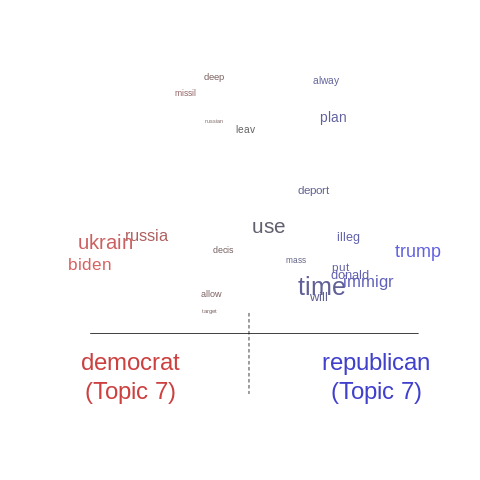

In [61]:
%%R
plot(fit, type = "perspectives", topics = 7)